<a href="https://colab.research.google.com/github/Jerry086/SALSA/blob/main/Audio_Embeddings_Distance_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd

metadata = pd.read_csv('/content/drive/MyDrive/audioset/audio_metadata.csv')
embeddings = pd.read_csv('/content/drive/MyDrive/audioset/audio_embeddings.csv')

merged_df = pd.merge(metadata, embeddings, on='video_id')

# print(metadata.head())
# print(embeddings.head())
merged_df

,video_id,start_time_seconds,end_time_seconds,labels,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_1270,feature_1271,feature_1272,feature_1273,feature_1274,feature_1275,feature_1276,feature_1277,feature_1278,feature_1279
0,wqoOX8K8DEU,30.0,40.0,"[396, 397]",89,255,19,54,240,199,...,101,152,255,0,194,190,0,91,247,251
1,wqH6Sj_h948,120.0,130.0,"[0, 441, 443]",89,74,221,113,99,254,...,98,38,255,0,255,255,124,29,0,255
2,wq1098my4zA,130.0,140.0,"[27, 137, 271]",224,124,142,123,113,144,...,72,116,62,197,89,51,212,44,112,177
3,wqR7LHho-WE,10.0,20.0,"[0, 22, 25]",147,207,173,147,216,98,...,86,81,91,123,192,51,255,255,101,0
4,wq6Me-UUbSc,360.0,370.0,[413],70,90,168,90,220,90,...,91,184,83,32,131,167,167,111,180,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21777,2w6tV5kDGWo,240.0,250.0,[178],155,99,141,33,81,109,...,217,196,195,104,81,0,47,194,56,196
21778,2wZCoeq9Ppc,80.0,90.0,"[137, 138, 185, 195, 196, 198, 268]",102,255,136,0,0,95,...,80,0,233,146,255,200,0,0,0,96
21779,2wajg-UP-Gs,0.0,10.0,[459],132,72,60,190,75,6,...,255,156,156,35,255,0,0,255,255,0
21780,lZavPVn7O4Q,180.0,190.0,"[137, 258, 260, 273]",224,112,85,133,151,193,...,127,207,66,83,106,204,154,74,145,62


In [5]:
features = merged_df.drop(columns=['video_id', 'start_time_seconds', 'end_time_seconds', 'labels']).values

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KDTree

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply PCA to reduce dimensions from 1280 to 128
pca = PCA(n_components=128)
features_reduced = pca.fit_transform(features_scaled)

kd_tree = KDTree(features_reduced, leaf_size=40, metric='euclidean')

# Query the KDTree for the nearest point to each point (k=2)
distances, indices = kd_tree.query(features_reduced, k=2)

# The distances array will contain distances to the nearest point (excluding itself)
# So we take all rows and the second column ([i][1])
nearest_distances = distances[:, 1]

print("Nearest distances for each point:", nearest_distances)

nearest_indices = indices[:, 1]

print("Indices of nearest neighbors for each point:", nearest_indices)

Nearest distances for each point: [19.27873462 17.26831291 13.63764187 ... 14.34744524 11.60405999
 19.20620116]
Indices of nearest neighbors for each point: [15016  5592 17960 ... 21234 10491  3845]


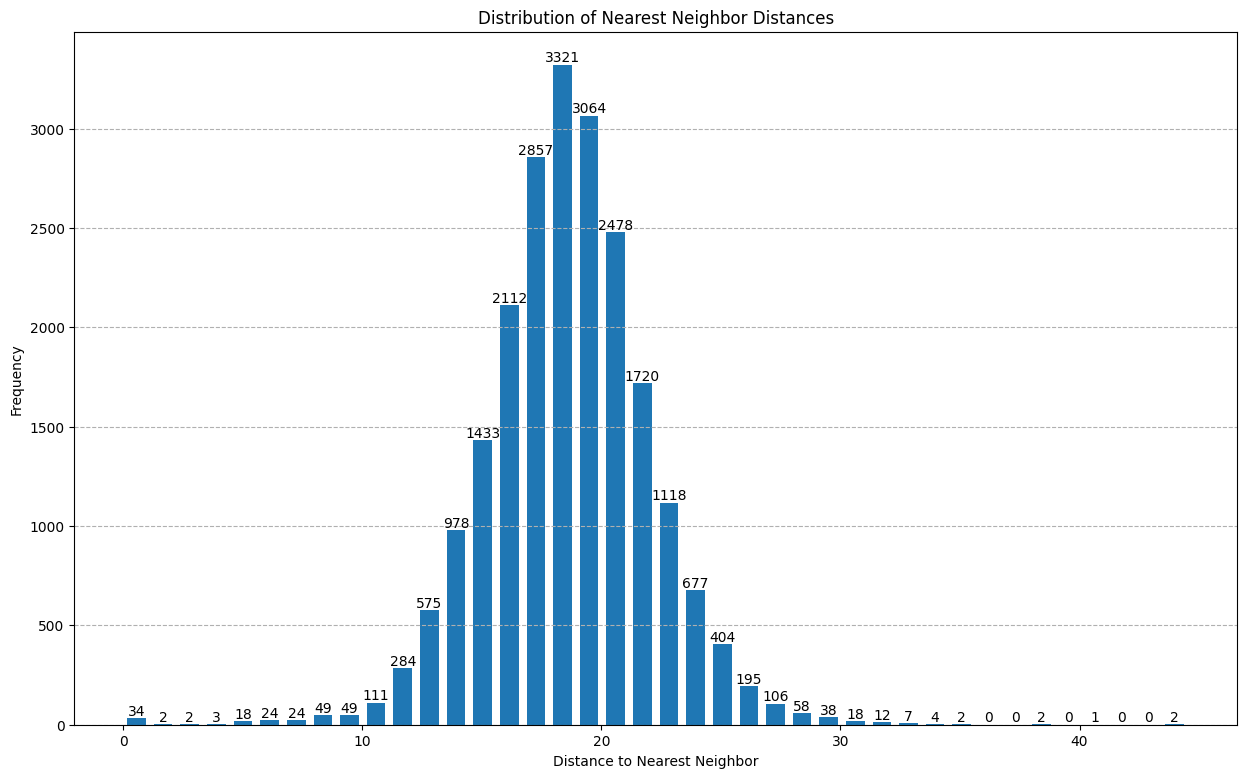

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Generate a histogram of the nearest distances
num_bins = 40
hist, bins = np.histogram(nearest_distances, bins=num_bins)

# Calculate the width of each bin for the bar graph
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

# Create a figure for the plot
plt.figure(figsize=(15, 9))

# Plot the bar graph
bars = plt.bar(center, hist, align='center', width=width)
plt.xlabel('Distance to Nearest Neighbor')
plt.ylabel('Frequency')
plt.title('Distribution of Nearest Neighbor Distances')
plt.grid(axis='y', linestyle='--')

# Annotate each bar with the frequency value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.show()

In [14]:
unique_indices = set(nearest_indices)
has_duplicates = len(nearest_indices) - len(unique_indices)
print(has_duplicates)

10457


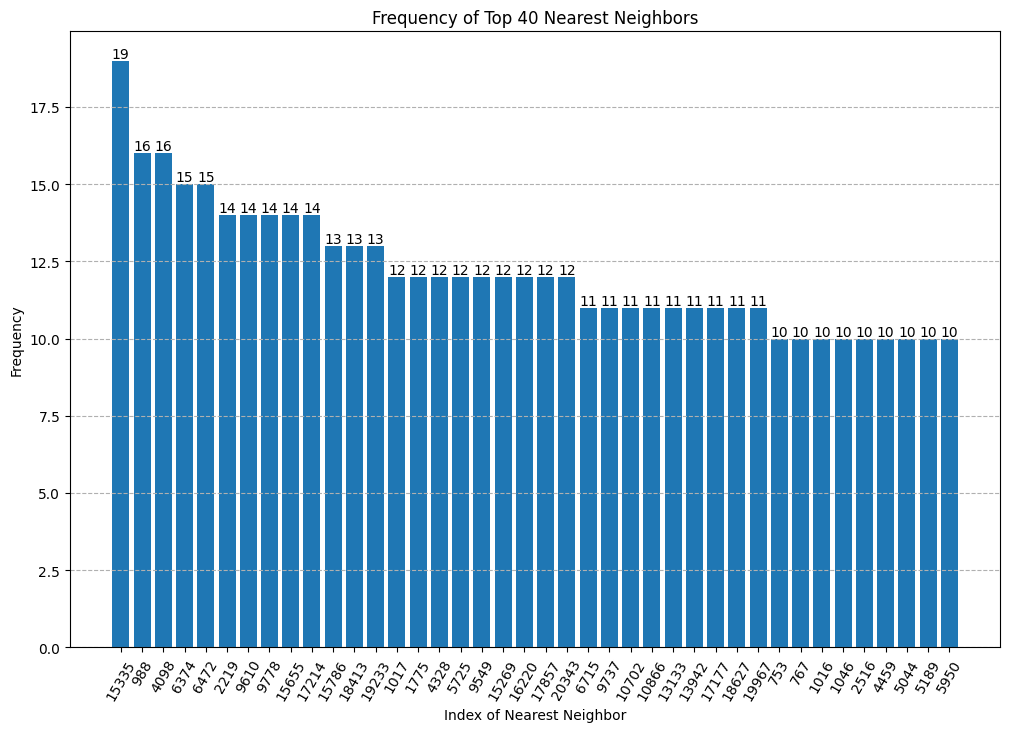

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Count the frequency of each index in nearest_indices
unique, counts = np.unique(nearest_indices, return_counts=True)
index_freq = dict(zip(unique, counts))

# Sort the frequencies in descending order and select the top 40
top_40_freq = sorted(index_freq.items(), key=lambda x: x[1], reverse=True)[:40]
top_40_indices = [item[0] for item in top_40_freq]
top_40_counts = [item[1] for item in top_40_freq]

# Create a bar graph for the top 40 nearest neighbor indices
plt.figure(figsize=(12, 8))
bars = plt.bar(range(len(top_40_indices)), top_40_counts, tick_label=top_40_indices)
plt.xlabel('Index of Nearest Neighbor')
plt.ylabel('Frequency')
plt.title('Frequency of Top 40 Nearest Neighbors')
# Rotate labels to avoid overlap
plt.xticks(rotation=60)
plt.grid(axis='y', linestyle='--')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.show()

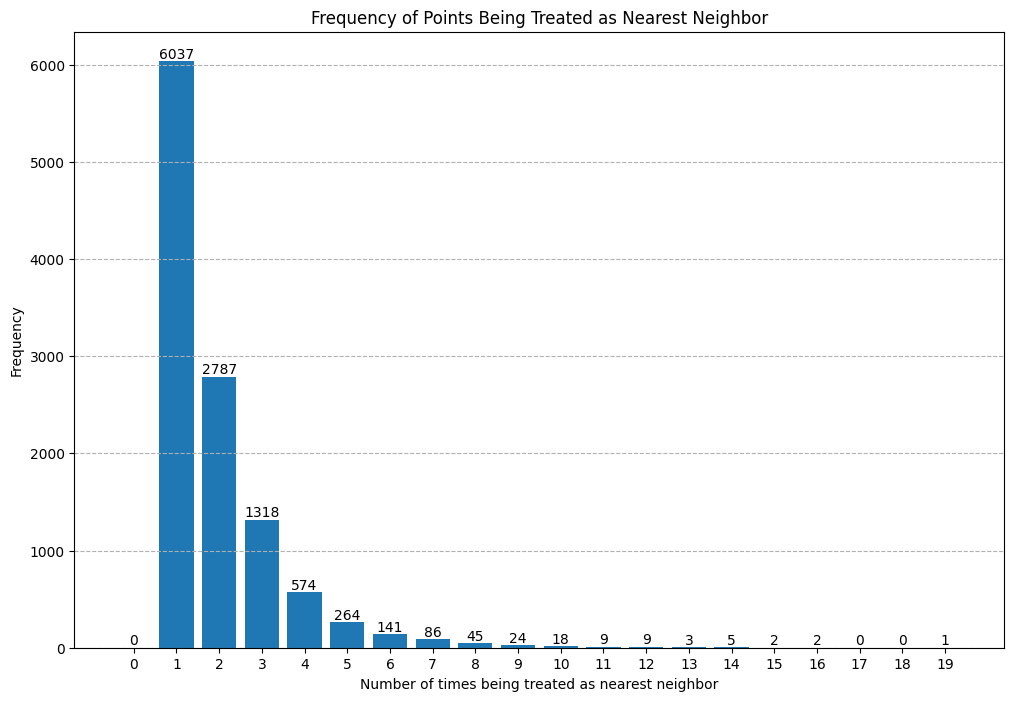

In [22]:
import numpy as np
import matplotlib.pyplot as plt

_, counts = np.unique(nearest_indices, return_counts=True)

# Calculate the frequency of frequencies within the range 0 to 19
freq_range = np.arange(20)
freq_of_freqs = [np.sum(counts == i) for i in freq_range]

# Plot the bar graph
plt.figure(figsize=(12, 8))
bars = plt.bar(freq_range, freq_of_freqs)
plt.xlabel('Number of times being treated as nearest neighbor')
plt.ylabel('Frequency')
plt.title('Frequency of Points Being Treated as Nearest Neighbor')
plt.xticks(freq_range)
plt.grid(axis='y', linestyle='--')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.show()

In [24]:
import numpy as np

# Calculate the 90th percentile of the nearest distances
percentile_90 = np.percentile(nearest_distances, 90)
percentile_80 = np.percentile(nearest_distances, 80)
percentile_70 = np.percentile(nearest_distances, 70)

print(percentile_90)
print(percentile_80)
print(percentile_70)

22.65838569874006
21.159694601896057
20.177118298003933
